In [29]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
import cv2
from imutils.contours import sort_contours
import imutils

In [2]:
src = "digitData/train/"
sub_class = os.listdir(src)

### Exploratory Data Analysis
Plotting few Images from train data

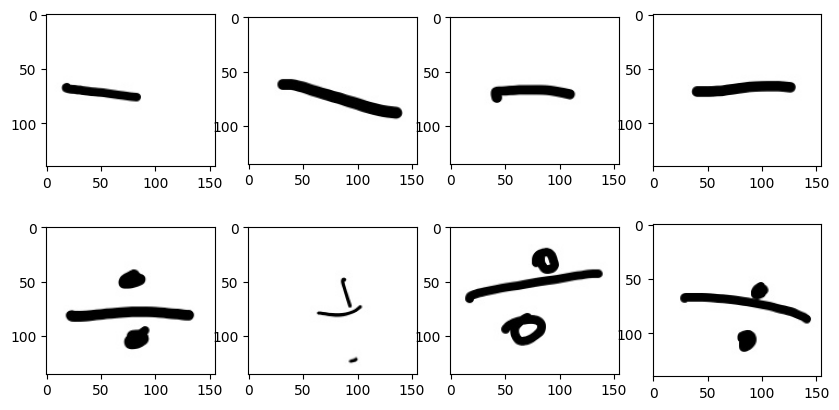

In [3]:
fig = plt.figure(figsize=(10,5))
path = os.path.join(src,sub_class[0])
for i in range(4):
    plt.subplot(240 + 1 + i)
    img = plt.imread(os.path.join(path,str(i)+'.jpg'))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

path = os.path.join(src,sub_class[1])
for i in range(4,8):
    plt.subplot(240 + 1 + i)
    img = plt.imread(os.path.join(path,str(i)+'.jpg'))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sys
import PIL
from PIL import Image
sys.modules['Image'] = Image

2023-07-02 09:34:16.633947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 09:34:17.468731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
src_train = "digitData/train"
src_test = "digitData/eval"
src_example = "digitData/example"

### Data generator 
This code below defines two ImageDataGenerators for preprocessing image data. The `image_datagen` applies transformations like rescaling, rotation, shifts, zoom, shear, and splits data for validation. It is used for training and validation sets. The `test_datagen` only rescales the image and is used for the test set.

In [6]:
image_datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,
    rescale = 1. /255,
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False,
    shear_range = 0.1,
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False, 
    validation_split = 0.15
)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

### Dataset preparation
This code below is creating data generators for training, validation, and testing data sets from directories. The `flow_from_directory` function loads images, converts them to grayscale, resizes to 28x28, and labels them based on directory structure. The training and validation generators shuffle the data, while the test generator does not.

In [41]:
batch_size = 32
train_generator = image_datagen.flow_from_directory(
    directory=src_train,
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=1
)

valid_generator = image_datagen.flow_from_directory(
    directory=src_train,
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=1
)

test_generator = test_datagen.flow_from_directory(
    directory=src_test,
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 5995 images belonging to 15 classes.
Found 1049 images belonging to 15 classes.
Found 933 images belonging to 15 classes.


### Model architecture and training

In [42]:
tf.random.set_seed(1234)
model = Sequential(
    [
        #layer1
        Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (32, 32, 1)),
        Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.25),
        
        #layer2
        Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"),
        Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.25),
        
        #fully connected layer
        Flatten(),
        Dense(256, activation = "relu"),
        Dropout(0.25),
        Dense(15, activation = "softmax")       
        
    ]
)


In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [44]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.0005),
    metrics = ["accuracy"]
)

In [45]:
model.fit(
    train_generator,
    validation_data = train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    verbose = 1,
    epochs=10
)


Epoch 1/10


2023-07-02 09:55:15.603185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-02 09:55:16.233120: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


185/187 [============================>.] - ETA: 0s - loss: 2.0722 - accuracy: 0.3112

2023-07-02 09:55:21.052655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


187/187 [==============================] - 6s 22ms/step - loss: 2.0651 - accuracy: 0.3134 - val_loss: 1.0325 - val_accuracy: 0.6904
Epoch 2/10
187/187 [==============================] - 4s 19ms/step - loss: 0.9279 - accuracy: 0.7102 - val_loss: 0.6002 - val_accuracy: 0.8164
Epoch 3/10
187/187 [==============================] - 4s 20ms/step - loss: 0.6098 - accuracy: 0.8087 - val_loss: 0.4117 - val_accuracy: 0.8779
Epoch 4/10
187/187 [==============================] - 4s 19ms/step - loss: 0.4775 - accuracy: 0.8524 - val_loss: 0.2989 - val_accuracy: 0.9082
Epoch 5/10
187/187 [==============================] - 3s 19ms/step - loss: 0.3919 - accuracy: 0.8788 - val_loss: 0.2721 - val_accuracy: 0.9111
Epoch 6/10
187/187 [==============================] - 4s 19ms/step - loss: 0.3287 - accuracy: 0.8969 - val_loss: 0.2143 - val_accuracy: 0.9414
Epoch 7/10
187/187 [==============================] - 3s 19ms/step - loss: 0.3004 - accuracy: 0.9104 - val_loss: 0.2231 - val_accuracy: 0.9336
Epoch 8/10

In [47]:
model.save("/home/abhi/Documents/epoch_hackathon/hw_model.h5")

In [21]:
#model.predict("/home/abhi/Documents/epoch_hackathon/digitData/eval/div val/184.jpg")
predict=model.predict(test_generator)
y_classes = predict.argmax(axis=-1)

2023-07-02 09:41:38.651693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


933/933 [==============================] - 1s 1ms/step


In [22]:
y_classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  5,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  0,  2,  2,  2,  2,  2,  2,  2,  5,  2,  2,  2,  2,
        2,  2,  2,  2,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  5,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,
        0,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

In [48]:
model = tf.keras.models.load_model("/home/abhi/Documents/epoch_hackathon/hw_model.h5")

In [49]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_classes]

In [92]:
print(predictions)

['div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'plus', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'times', 'div', 'div', 'div', 'plus', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'six', 'six', 'eight', 'six', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'six', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'six', 'six', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'eight', 'six', 'eight', 'eight', 'five', 'eigh

In [25]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'div', 1: 'eight', 2: 'equal', 3: 'five', 4: 'four', 5: 'minus', 6: 'nine', 7: 'one', 8: 'plus', 9: 'seven', 10: 'six', 11: 'three', 12: 'times', 13: 'two', 14: 'zero'}


### Extracting each character
The code reads and processes an image (resizing, grayscaling, blurring, and edge detection).
Contours are found in the processed image and sorted from left to right.
For each contour, a bounding box is created and the enclosed region is extracted, if the box's size is appropriate.
The extracted regions (characters) are further processed (thresholded, resized, padded, and normalized) for CNN model.
Processed characters and their bounding boxes are stored for later use, such as classification by an CNN model.


Invalid SOS parameters for sequential JPEG


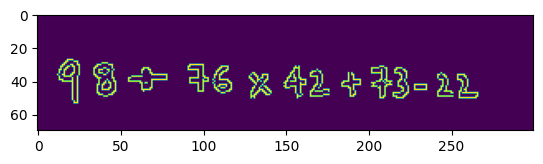

In [75]:
image = cv2.imread("/home/abhi/Downloads/testing2.jpg")
image = cv2.resize(image, (300, 70))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 50, 150)
cv2.imwrite("edged.jpg", edged)
plt.imshow(edged)
plt.show()
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
digits = []
for c in cnts:
# compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 3 and w <= 70) and (h >= 3 and h <= 70):
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        # if the width is greater than the height, resize along the
        # width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)
        # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=32)
            
        (tH, tW) = thresh.shape
        dX = int(max(0, 50 - tW) / 2.0)
        dY = int(max(0, 50 - tH) / 2.0)
        
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))
        padded = 255 - padded
        padded = padded / 255.0
        padded = np.expand_dims(padded, axis=-1)
        
        digits.append((padded, (x, y, w, h)))
        
boxes = [b[1] for b in digits]
digits = np.array([c[0] for c in digits], dtype="float32")


Plotting one of the detected characters above to verify

1/1 [==============================] - 0s 14ms/step
[0]


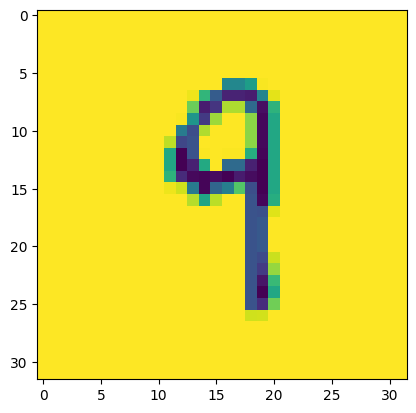

In [76]:
pred_val = model.predict(digits[2].reshape(-1,32,32,1))
pred_val = np.argmax(pred_val, axis = 1)
print(pred_val)
plt.imshow(digits[0])
plt.show()

### Model prediction on each extracted character and expression computation
This code segment below is predicting and decoding the labels of preprocessed character images for CNN. The `labels` dictionary maps numerical labels to their string representation. The `num_map` dictionary further maps these strings to mathematical notations. For each character image in `digits`, it predicts the label using a model, decodes it to the corresponding mathematical notation, and appends it to the result string. Finally, it prints the resulting mathematical expression and evaluates it using Python's built-in `eval` function.

In [77]:
labels = {0: 'div', 1: 'eight', 2: 'equal', 3: 'five', 4: 'four', 5: 'minus', 6: 'nine', 7: 'one', 8: 'plus', 9: 'seven', 10: 'six', 11: 'three', 12: 'times', 13: 'two', 14: 'zero'}
num_map = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'zero': 0, 'times': '*', 'div': '/', 'plus': '+', 'minus': '-'}
result = ""
for i in range(len(digits)):
    pred_val = model.predict(digits[i].reshape(-1,32,32,1))
    pred_val = np.argmax(pred_val, axis = 1)
    result = result + str(num_map[labels[pred_val[0]]])
print('--------------------------------------')
print("Converted expression string: ", result)
print("Evaluated expression = ", eval(result))

1/1 [==============================] - 0s 18ms/step
--------------------------------------
Converted expression string:  98/76*42+73-22
Evaluated expression =  105.15789473684211
